# Import necessary libraries

In [1]:
# Install torch_snippets library
!pip install torch_snippets

from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision.models import vgg19

# Set device to GPU if available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.8 MB/s eta 0:

# Define preprocessing and postprocessing transformations for images

In [2]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])



# Define GramMatrix class for computing Gram matrix of features

In [3]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        feat = input.view(b, c, h*w)
        G = feat @ feat.transpose(1, 2)
        G.div_(h*w)
        return G


# Define GramMSELoss class for computing the Gram matrix mean squared error loss

In [4]:
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return out


# Define vgg19_modified class as a modified version of the VGG19 model

In [5]:
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        # Load VGG19 model with pretrained weights
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()

    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers:
                _results.append(x)
        for o in order:
            results.append(_results[o])
        return results if layers != [] else x


In [6]:
# Instantiate the vgg19_modified model and move it to the specified device
vgg = vgg19_modified().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 69.3MB/s]


In [7]:
# Download example images
!wget https://e0.365dm.com/21/02/1600x900/skysports-zlatan-ibrahimovic_5266629.jpg
!wget https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg
!ls


--2023-11-30 08:01:33--  https://e0.365dm.com/21/02/1600x900/skysports-zlatan-ibrahimovic_5266629.jpg
Resolving e0.365dm.com (e0.365dm.com)... 23.53.122.76, 23.53.122.75, 2600:1409:9800:20::1735:7a4c, ...
Connecting to e0.365dm.com (e0.365dm.com)|23.53.122.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285118 (278K) [image/jpeg]
Saving to: ‘skysports-zlatan-ibrahimovic_5266629.jpg’

skysports-zlatan-ib 100%[===================>] 278.44K  --.-KB/s    in 0.03s   

2023-11-30 08:01:33 (9.58 MB/s) - ‘skysports-zlatan-ibrahimovic_5266629.jpg’ saved [285118/285118]

--2023-11-30 08:01:33--  https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg
Resolving www.neh.gov (www.neh.gov)... 23.21.228.79
Connecting to www.neh.gov (www.neh.gov)|23.21.228.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5309491 (5.1M) [image/jpeg]
Saving to: ‘Fall_2022_web-images_Picasso_32.jpg’

Fall_2022_web-image 100%[============

# Load and preprocess images

In [8]:
imgs = [Image.open(path).resize((512, 512)).convert('RGB') for path in ['Fall_2022_web-images_Picasso_32.jpg', 'skysports-zlatan-ibrahimovic_5266629.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]


In [9]:
# Create a copy of the content image for optimization
opt_img = content_image.data.clone()
opt_img.requires_grad = True


# Define the layers for style and content in the VGG network

In [10]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers


# Define loss functions for style and content

In [11]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]


# Define weights for style and content losses

In [12]:
style_weights = [1000/n**2 for n in [64, 128, 256, 512, 512]]
content_weights = [1]
weights = style_weights + content_weights


# Compute style and content targets

In [13]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets


# Optimization

In [14]:
# Set the maximum number of optimization iterations
max_iters = 500

# Set up the LBFGS optimizer for optimization
optimizer = optim.LBFGS([opt_img])

# Initialize logging for optimization progress
log = Report(max_iters)
iters = 0

# Optimization loop
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss

    optimizer.step(closure)


EPOCH: 502.000  loss: 872265.375  (66.86s - -0.27s remaining)

# Plot optimization progress

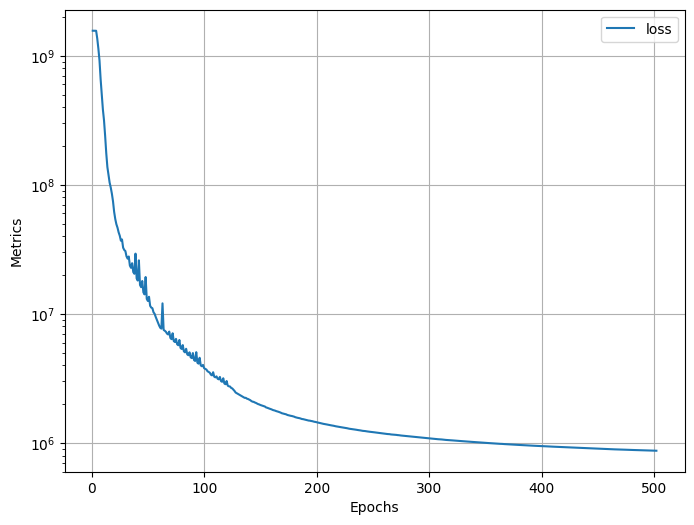

In [15]:
log.plot(log=True)


# Display the final stylized image

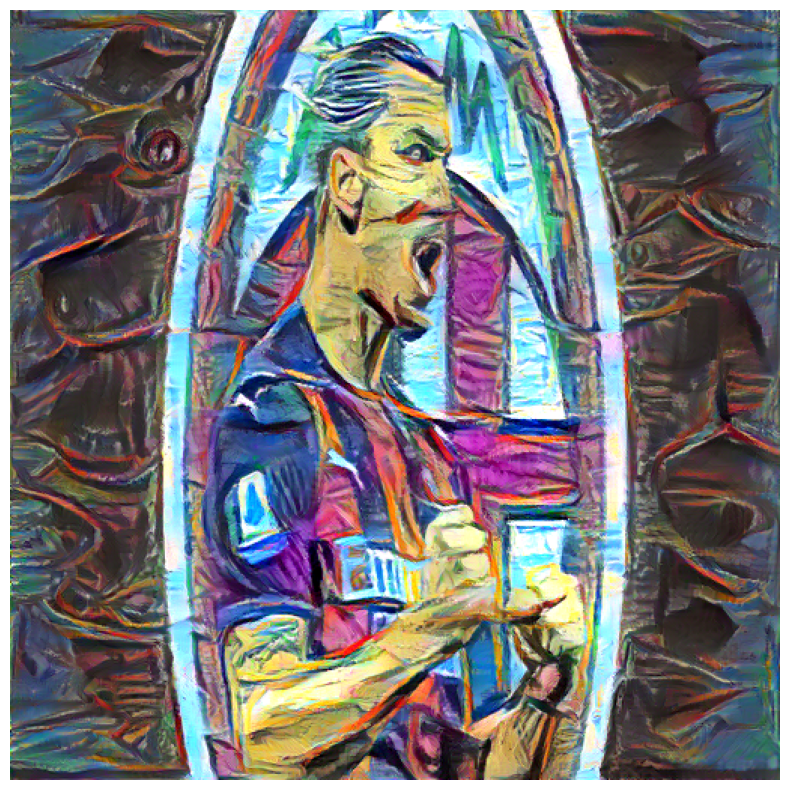

In [16]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1, 2, 0)
show(out_img)
